In [1]:
%matplotlib widget
from ipywidgets import *
from astropy.io import fits
import astropy.time as time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2 as cv
from scipy import ndimage
from skimage.morphology import dilation, disk
import pandas as pd

In [2]:
cube = fits.open('Data/visit_PR149000_TG009801/CH_PR149000_TG008901_TU2024-01-13T03-18-13_SCI_RAW_SubArray_V0300.fits')
cube.info()

SubArray = cube[1].data
#MetaData = cube[9].data

cube.close()
#print(cube[1].header)

corrected = fits.open('Data/Corrected_Data/CH_PR149000_TG008901_TU2024-01-13T03-18-13_SCI_COR_SubArray_V0300.fits')

SubArray_corr = cube[1].data

Filename: Data/visit_PR149000_TG009801/CH_PR149000_TG008901_TU2024-01-13T03-18-13_SCI_RAW_SubArray_V0300.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SCI_RAW_SubArray    1 ImageHDU       108   (200, 200, 224)   int32 (rescales to uint32)   
  2  SCI_RAW_BlankLeft    1 ImageHDU        89   (8, 200, 224)   float32   
  3  SCI_RAW_BlankRight    1 ImageHDU        89   (8, 200, 224)   float32   
  4  SCI_RAW_DarkLeft    1 ImageHDU        89   (16, 200, 224)   float32   
  5  SCI_RAW_DarkRight    1 ImageHDU        89   (16, 200, 224)   float32   
  6  SCI_RAW_DarkTop    1 ImageHDU        89   (200, 3, 224)   float32   
  7  SCI_RAW_OverscanLeft    1 ImageHDU        89   (4, 200, 224)   float32   
  8  SCI_RAW_OverscanTop    1 ImageHDU        89   (200, 6, 224)   float32   
  9  SCI_RAW_ImageMetadata    1 BinTableHDU    197   224R x 38C   [1K, 26A, 1D, 1D, 1D, 1D, 1E, 1E, 1K, 26A, 1I, 1J, 1B, 1I, 1I, 5A, 1E, 1E, 1E,

In [3]:
lightcurve = 'Data/visit_PR149000_TG009801/CH_PR149000_TG008901_TU2024-01-13T03-18-13_SCI_COR_Lightcurve-DEFAULT_V0300.fits'
lightcurve_file = fits.open(lightcurve)
lightcurve_data = lightcurve_file[1].data
lightcurve_header = lightcurve_file[1].header
lightcurve_file.close()

time = lightcurve_data['BJD_TIME']
roll_angle = lightcurve_data['ROLL_ANGLE']

print(roll_angle)

[331.76755548 327.73150094 323.70920473 319.70689316 315.73135921
 311.78799396 307.88173135 304.01659939 300.19550664 296.42120376
 292.69433456 289.01551827 285.38441179 281.79982683 278.25978833
 274.76199056 271.30339893 267.88058406 264.49003823 261.12739521
 257.78833273 254.4685688  251.16327809 247.86730544 244.57642176
 241.28545933  99.61630965  96.09015339  92.60347003  89.15374091
  85.73685296  82.34885818  78.98581012  75.64317345  72.31599048
  69.00011462  65.69010443  62.38149564  59.06926314  55.74836501
  52.41424048  49.06200252  45.68697137  42.28514659  38.85227084
  35.38428527  31.87782475  28.33006276  24.73854069  21.10105301
  17.41678199  13.6847914    9.90589535   6.08098436   2.21222036
 358.30301155 354.35685416 350.37901759 346.37477403 342.35062493
 338.31342297 334.27024062 330.22863682 326.19584588 322.17854871
 318.184241   314.21830166 310.28680231 306.39383412 302.54334761
 298.73780266 294.9796908  291.26951159 287.60724505 283.99249145
 280.42380

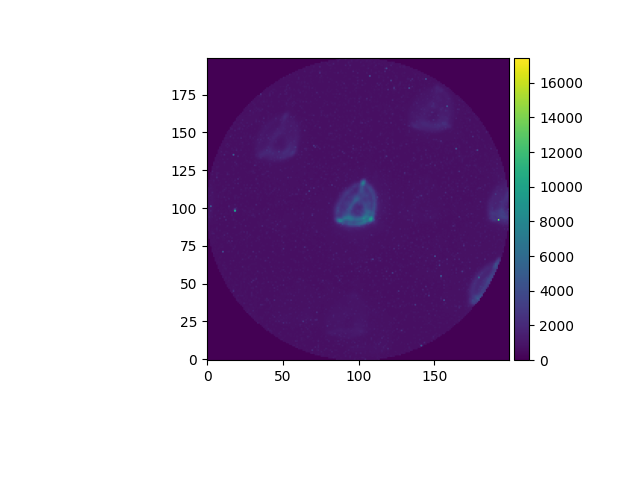

In [3]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)


# adjust plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)
im = ax.imshow(SubArray_corr[2,:,:])
ax.invert_yaxis()
fig.colorbar(im, cax=cax, orientation='vertical' )

"""
#Slider - currently not working as intended

axslider = plt.axes([0.25, 0.15, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 200, valstep=1)

def update(val):
    array = SubArray[val,:,:]
    ax.imshow(array)
slider.on_changed(update)
"""
plt.show()
plt.savefig("Cheops_w_backgroundstars.png")

In [5]:
def maximumBrightness(data):
    max_Value = np.argmax(data)
    #max_Position = np.unravel_index(max_Value, data.shape)
    
    return max_Value

def count(array, condition):
    return np.sum(array > condition)

median = np.median(SubArray[:,:,:], axis=0)
mean = np.mean(SubArray[:,:,:], axis=0)

In [6]:
# Histogram currently not working alongside slider

'''
#reshape array from 3d to 2d
reshaped_Array = SubArray.reshape(-1, SubArray.shape[-1])
#plot a histogram
plt.hist(reshaped_Array, bins=100)
plt.ylim(top=25000)
plt.xlim(right=7000)
plt.show()
'''

'\n#reshape array from 3d to 2d\nreshaped_Array = SubArray.reshape(-1, SubArray.shape[-1])\n#plot a histogram\nplt.hist(reshaped_Array, bins=100)\nplt.ylim(top=25000)\nplt.xlim(right=7000)\nplt.show()\n'

In [7]:
print(SubArray[:,:,:].shape)

(224, 200, 200)


In [8]:
#roll angle correction

#SubArray_corr_roll = np.zeros([224,200,200])

def roll_angle_correction(data_array, roll_angle_array):
    rotated_array= np.zeros([224,200,200])
    for i in range(0,224):
        for j in range(len(roll_angle_array)):
            rotated_array += ndimage.rotate(data_array[i,:,:], roll_angle_array[j], reshape=False)
            return rotated_array

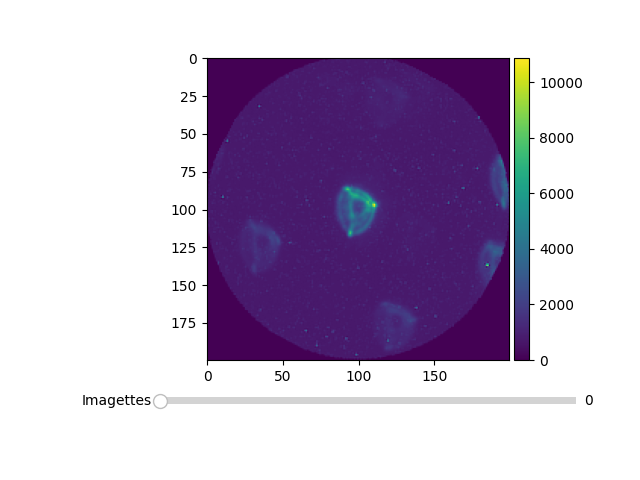

In [9]:
SubArray_corrected = roll_angle_correction(SubArray, roll_angle)

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

# adjust plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)
im = ax.imshow(SubArray_corrected[0,:,:])
fig.colorbar(im, cax=cax, orientation='vertical' )

#Slider - currently not working alongside histogram

axslider = plt.axes([0.25, 0.15, 0.65, 0.03])
slider = Slider(axslider, 'Imagettes', 0, 200, valstep=1)

def update(val):
    array = SubArray_corrected[val,:,:]
    ax.imshow(array)
slider.on_changed(update)

plt.show()

In [10]:
median_rotated = np.median(SubArray_corrected[:,:,:], axis=0)
mean_rotated = np.mean(SubArray_corrected[:,:,:], axis=0)

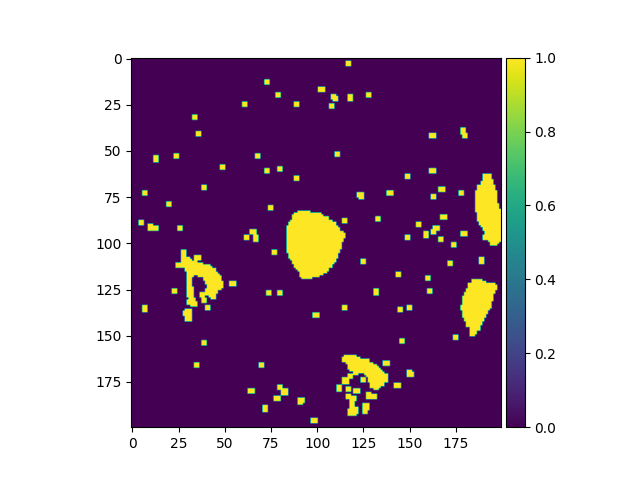

In [11]:
#defining a filter
filteredArray= ndimage.median_filter(SubArray_corrected, size = 3) #filter radius = 3

'''
#creating the mask
#with filter

mask_w_filter = filteredArray > 2000  #threshold to be improved  
maskedArray_w_filter = filteredArray.copy()
maskedArray_w_filter[mask_w_filter] = 0
'''

#without filter
mask_wo_filter = SubArray_corrected > 2000
maskedArray_wo_filter = SubArray_corrected.copy()
maskedArray_wo_filter[mask_wo_filter] = 0

#dilate mask
#from median
alternative_mask = np.zeros(np.shape(median_rotated))
alternative_mask[mean_rotated > 1500] = 1

# Define the kernel for mask enlargment dilation
kernel = np.ones((3,3), dtype=np.uint8)

# Dilate mask
enlarged_mask = cv.dilate(alternative_mask, kernel, iterations=1)

footprint = disk(6)
#maskDilation = dilation(maskedArray[0,:,:], footprint)

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(enlarged_mask)
fig.colorbar(im, cax=cax, orientation='vertical' )
plt.show()

In [12]:
#Bad Pixel Maps
pixel_cube = fits.open('Data/visit_PR149000_TG009801/CH_TU2024-01-17T06-08-01_REF_APP_BadPixelMap_V0300.fits')
pixel_cube.info()

Filename: Data/visit_PR149000_TG009801/CH_TU2024-01-17T06-08-01_REF_APP_BadPixelMap_V0300.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  REF_APP_BadPixelMap    1 ImageHDU        58   (1024, 1024)   int16   
  2  REF_APP_BadPixelMapLeft    1 ImageHDU        42   (16, 1024)   int16   
  3  REF_APP_BadPixelMapRight    1 ImageHDU        42   (16, 1024)   int16   
  4  REF_APP_BadPixelMapTop    1 ImageHDU        42   (1024, 3)   int16   
  5  REF_APP_PhotPixelMap    1 ImageHDU        35   (1024, 1024)   uint8   
  6  REF_APP_PhotPixelMapLeft    1 ImageHDU        36   (16, 1024)   uint8   
  7  REF_APP_PhotPixelMapRight    1 ImageHDU        36   (16, 1024)   uint8   
  8  REF_APP_PhotPixelMapTop    1 ImageHDU        36   (1024, 3)   uint8   


In [13]:
BadPixelMap = pixel_cube[1].data

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

# adjust plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)
im = ax.imshow(BadPixelMap)
fig.colorbar(im, cax=cax, orientation='vertical' )

 plt.show()

IndentationError: unexpected indent (745950746.py, line 12)

In [ ]:
print(np.max(BadPixelMap))

In [ ]:
design psf with median, removing bad pixels, derotate